## B0 calculations 
This will be (for now, maybe forever) a test script for the calculations and analysis of B0 fields

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import welch
import math

In [3]:
def read_csv_numpy(filename):
    data = np.loadtxt(filename, delimiter=',', skiprows=1)  # skiprows=1 if there's a header
    print(f"Data shape: {data.shape}")
    return data

#The function used for calculating the allan variance is based on:
#https://liquidinstruments.com/application-notes/understanding-and-performing-allan-variance-measurements/
def allan(y,t,n):
    tau_0 = (t[2]-t[1])*n
    K = len(y)
    truncated_length = (len(y) // n) * n
    y_truncated = y[:truncated_length]
    y_M = y_truncated.reshape(-1, n).mean(axis=1) #include overlapping algorythm, for n=1 every data point sampled
    N = math.log2(len(y_M))
    N = math.floor(N)
    sigma_y_sq = np.zeros(N)
    for i in range(0,N):
        m = i+1
        truncated_length = (len(y_M) // m) * m
        y = y_M[:truncated_length]
        y = y.reshape(-1, m).mean(axis=1) 
        K = len(y)
        for j in range (0,K-2):
            sigma_y_sq[i] = sigma_y_sq[i]+(y[j+1]-y[j])**2
            
        sigma_y_sq[i] = 1/(2*(K-1))*sigma_y_sq[i]
    sigma_y = np.sqrt(sigma_y_sq)
    return sigma_y, tau_0

def gaussian(x,A,x0,s):
    return A*np.exp(-(x-x0)**2/s**2)

def downsample(y,n):
    truncated_length = (len(y) // n) * n
    y_truncated = y[:truncated_length]
    y_M = y_truncated.reshape(-1, n).mean(axis=1) #include overlapping algorythm, for n=1 every data point sampled
    return y_M

In [4]:
louis = read_csv_numpy("C:/Users/ledel/QuantumHardwareLab/B0field/Data/raw/earth_room_louis.csv")
sri = read_csv_numpy("C:/Users/ledel/QuantumHardwareLab/B0field/Data/raw/earth_room_sri.csv")
ben = read_csv_numpy("C:/Users/ledel/QuantumHardwareLab/B0field/Data/raw/earth_room_ben.csv")
print(ben[0,0])
# [time, x, y, z, absolute]

Data shape: (499, 5)
Data shape: (1003, 5)
Data shape: (1003, 5)
0.01004487497


Here I want to now compare the 3 different data sets from 3 devices. First, I want to simply look at a histogram and calculate a gaussian to compare a the statistical models with each other. I will assume a normal distribution for now, depending on the allan deviation this might be proven or disproven!
Then we can turn to the allan deviation, this could help us understand the different statistic or systematic noise components
TODO: 
* this could be used to find a model and/or compare with other measurements
* can we find a correlation between these 3 devices

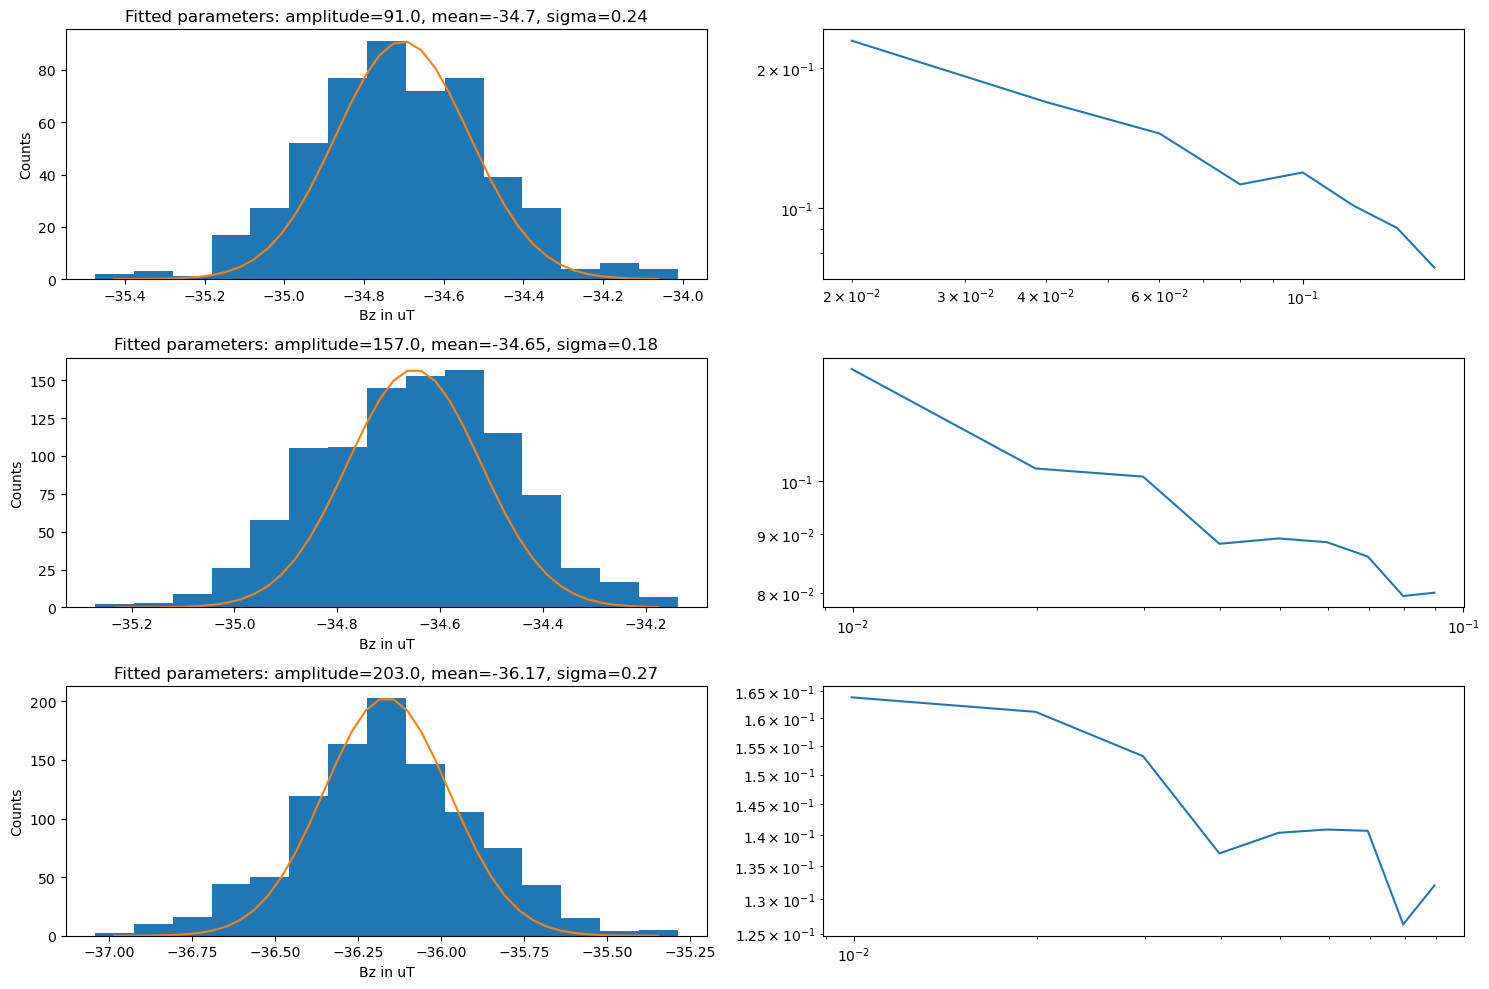

In [6]:
fig, ((ax1,ax4),(ax2,ax5),(ax3,ax6)) = plt.subplots(3, 2, figsize=(15, 10))

counts_l, bin_edges, patches = ax1.hist(louis[:,3],bins=15)
bins_l = (bin_edges[:-1] + bin_edges[1:]) / 2
#popt, pcov = curve_fit(gaussian, bins_l, counts_l, p0=[max(counts_l), np.mean(louis[:,3]), np.std(louis[:,3])])
#ax1.hist(louis[:,3], bins=50, label='Histogram')
#ax1.plot(bins_l, gaussian(bins_l, *popt), 'r-', linewidth=2, label='Fit')
range_l = np.linspace(bins_l[0],bins_l[14],40)
ax1.plot(range_l,gaussian(range_l,max(counts_l), np.mean(louis[:,3]), np.std(louis[:,3])))
ax1.set_title(f"Fitted parameters: amplitude={max(counts_l)}, mean={round(np.mean(louis[:,3]),2)}, sigma={round(np.std(louis[:,3]),2)}")
ax1.set_ylabel('Counts')
ax1.set_xlabel('Bz in uT')

allan_l,tau_l = allan(louis[:,3],louis[:,0],1)
tl = np.linspace(1,len(allan_l),len(allan_l))*tau_l
ax4.plot(tl,allan_l)
ax4.set_yscale('log')
ax4.set_xscale('log')

counts_b, bin_edges, patches = ax2.hist(ben[:,3],bins=15)
bins_b = (bin_edges[:-1] + bin_edges[1:]) / 2
range_b = np.linspace(bins_b[0],bins_b[14],40)
ax2.plot(range_b,gaussian(range_b,max(counts_b), np.mean(ben[:,3]), np.std(ben[:,3])))
ax2.set_title(f"Fitted parameters: amplitude={max(counts_b)}, mean={round(np.mean(ben[:,3]),2)}, sigma={round(np.std(ben[:,3]),2)}")
ax2.set_ylabel('Counts')
ax2.set_xlabel('Bz in uT')

allan_b, tau_b = allan(ben[:,3],ben[:,0],1)
tb = np.linspace(1,len(allan_b),len(allan_b))*tau_b
ax5.plot(tb,allan_b)
ax5.set_yscale('log')
ax5.set_xscale('log')

counts_s, bin_edges, patches = ax3.hist(sri[:,3],bins=15)
bins_s = (bin_edges[:-1] + bin_edges[1:]) / 2
range_s = np.linspace(bins_s[0],bins_s[14],40)
ax3.plot(range_s,gaussian(range_s,max(counts_s), np.mean(sri[:,3]), np.std(sri[:,3])))
ax3.set_title(f"Fitted parameters: amplitude={max(counts_s)}, mean={round(np.mean(sri[:,3]),2)}, sigma={round(np.std(sri[:,3]),2)}")
ax3.set_ylabel('Counts')
ax3.set_xlabel('Bz in uT')

allan_s, tau_s = allan(sri[:,3],sri[:,0],1)
ts = np.linspace(1,len(allan_s),len(allan_s))*tau_s
ax6.plot(ts,allan_s)
ax6.set_yscale('log')
ax6.set_xscale('log')

plt.tight_layout()  # Adjusts spacing
plt.show()

## Resimualting the data
I will use the assumed (and at this point sort of verified) normal distribution to generate a dataset (size chosen so to get 10 points for allan). However, I will redetermine the Gaussian parameters to see possible changes. 
=> as expected, similar but not the same!
Also, we can see that for the simulated data, the allan variation shows "purer" white noise as we get an even slope.

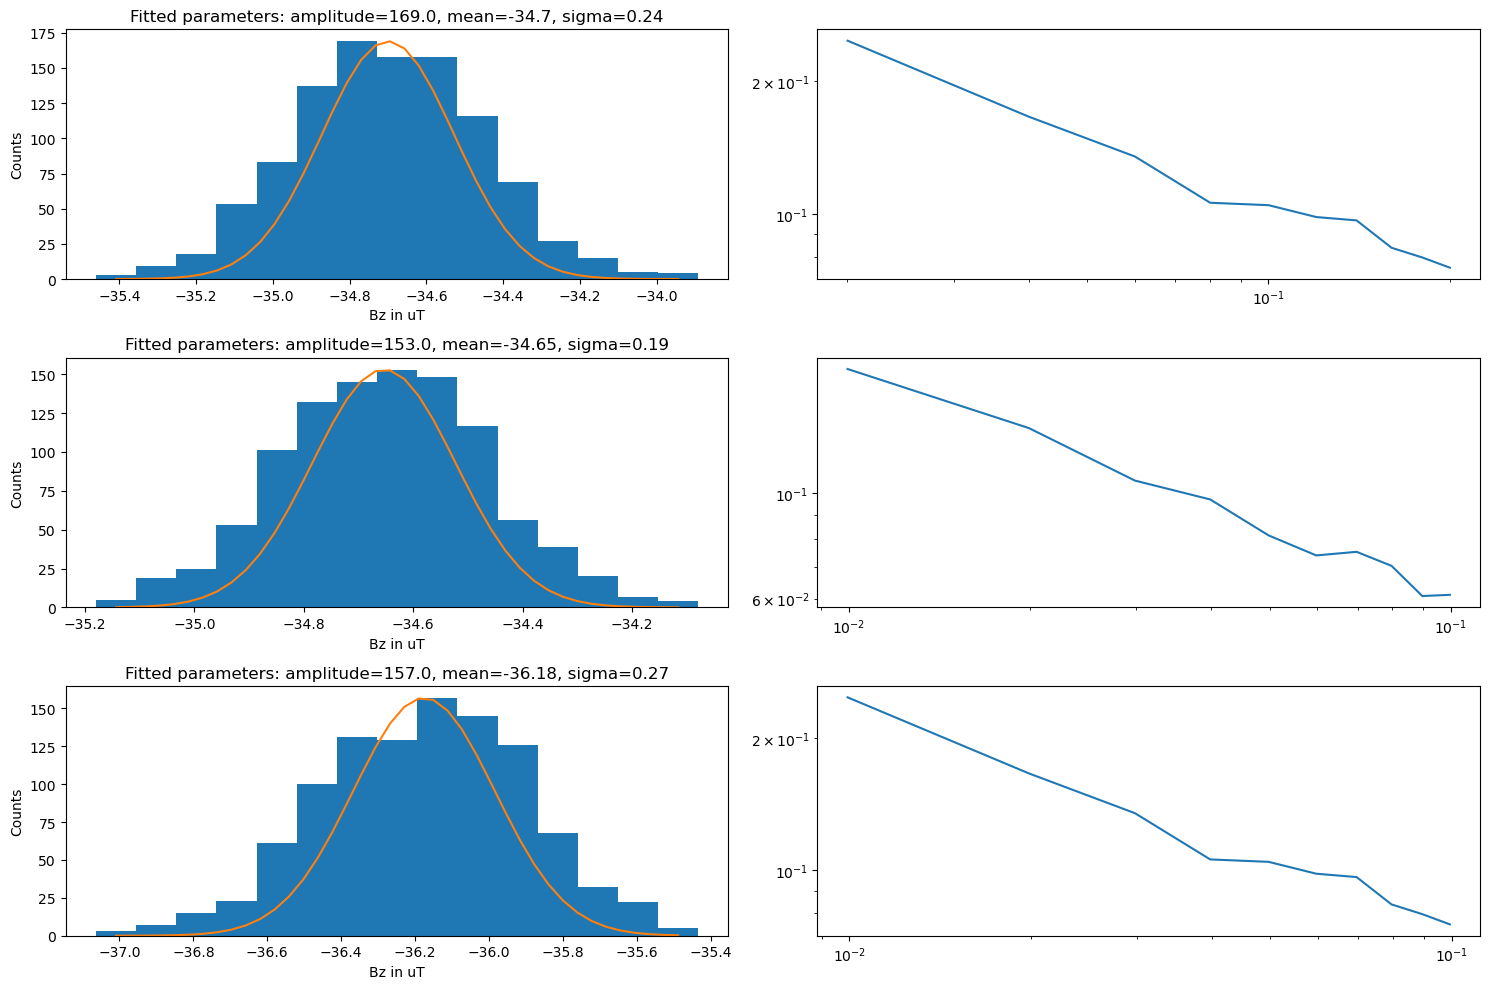

In [8]:
fig, ((ax1,ax4),(ax2,ax5),(ax3,ax6)) = plt.subplots(3, 2, figsize=(15, 10))

test_l = np.random.normal(np.mean(louis[:,3]), np.std(louis[:,3]),2**10)
counts_l, bin_edges, patches = ax1.hist(test_l,bins=15)
bins_l = (bin_edges[:-1] + bin_edges[1:]) / 2
range_l = np.linspace(bins_l[0],bins_l[14],40)
ax1.plot(range_l,gaussian(range_l,max(counts_l), np.mean(test_l), np.std(test_l)))
ax1.set_title(f"Fitted parameters: amplitude={max(counts_l)}, mean={round(np.mean(test_l),2)}, sigma={round(np.std(test_l),2)}")
ax1.set_ylabel('Counts')
ax1.set_xlabel('Bz in uT')

allan_tl, tau_tl = allan(test_l,louis[:,0],1)
ttl = np.linspace(1,len(allan_tl),len(allan_tl))*tau_tl
ax4.plot(ttl,allan_tl)
ax4.set_yscale('log')
ax4.set_xscale('log')

test_b = np.random.normal(np.mean(ben[:,3]), np.std(ben[:,3]),2**10)
counts_b, bin_edges, patches = ax2.hist(test_b,bins=15)
bins_b = (bin_edges[:-1] + bin_edges[1:]) / 2
range_b = np.linspace(bins_b[0],bins_b[14],40)
ax2.plot(range_b,gaussian(range_b,max(counts_b), np.mean(test_b), np.std(test_b)))
ax2.set_title(f"Fitted parameters: amplitude={max(counts_b)}, mean={round(np.mean(test_b),2)}, sigma={round(np.std(test_b),2)}")
ax2.set_ylabel('Counts')
ax2.set_xlabel('Bz in uT')

allan_tb, tau_tb = allan(test_b,ben[:,0],1)
ttb = np.linspace(1,len(allan_tb),len(allan_tb))*tau_tb
ax5.plot(ttb,allan_tb)
ax5.set_yscale('log')
ax5.set_xscale('log')

test_s = np.random.normal(np.mean(sri[:,3]), np.std(sri[:,3]),2**10)
counts_s, bin_edges, patches = ax3.hist(test_s,bins=15)
bins_s = (bin_edges[:-1] + bin_edges[1:]) / 2
range_s = np.linspace(bins_s[0],bins_s[14],40)
ax3.plot(range_s,gaussian(range_s,max(counts_s), np.mean(test_s), np.std(test_s)))
ax3.set_title(f"Fitted parameters: amplitude={max(counts_s)}, mean={round(np.mean(test_s),2)}, sigma={round(np.std(test_s),2)}")
ax3.set_ylabel('Counts')
ax3.set_xlabel('Bz in uT')

allan_ts, tau_ts = allan(test_l,sri[:,0],1)
tts = np.linspace(1,len(allan_ts),len(allan_ts))*tau_ts
ax6.plot(tts,allan_ts)
ax6.set_yscale('log')
ax6.set_xscale('log')

plt.tight_layout()  # Adjusts spacing
plt.show()

## Comparison of signals
I want to compare the noise characteristics of the three different devices. As the measurements have not been acquired simultaneously, we cannot simply use a cross correlation (I feel like measuring "likeliness" for "random" data will give me nothing of use). Instead, I will be going for a more straightforward approach which I am also familiar with, the power spectral density. This should allow me to identify the frequency properties of the noise directly. 
Also I will downsample my 100Hz data so that I have the same frequency ranges.

I will be using the welch function
https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html, 20.11.2025, 11:11
based on
https://en.wikipedia.org/wiki/Welch%27s_method, 20.11.2025, 11:11

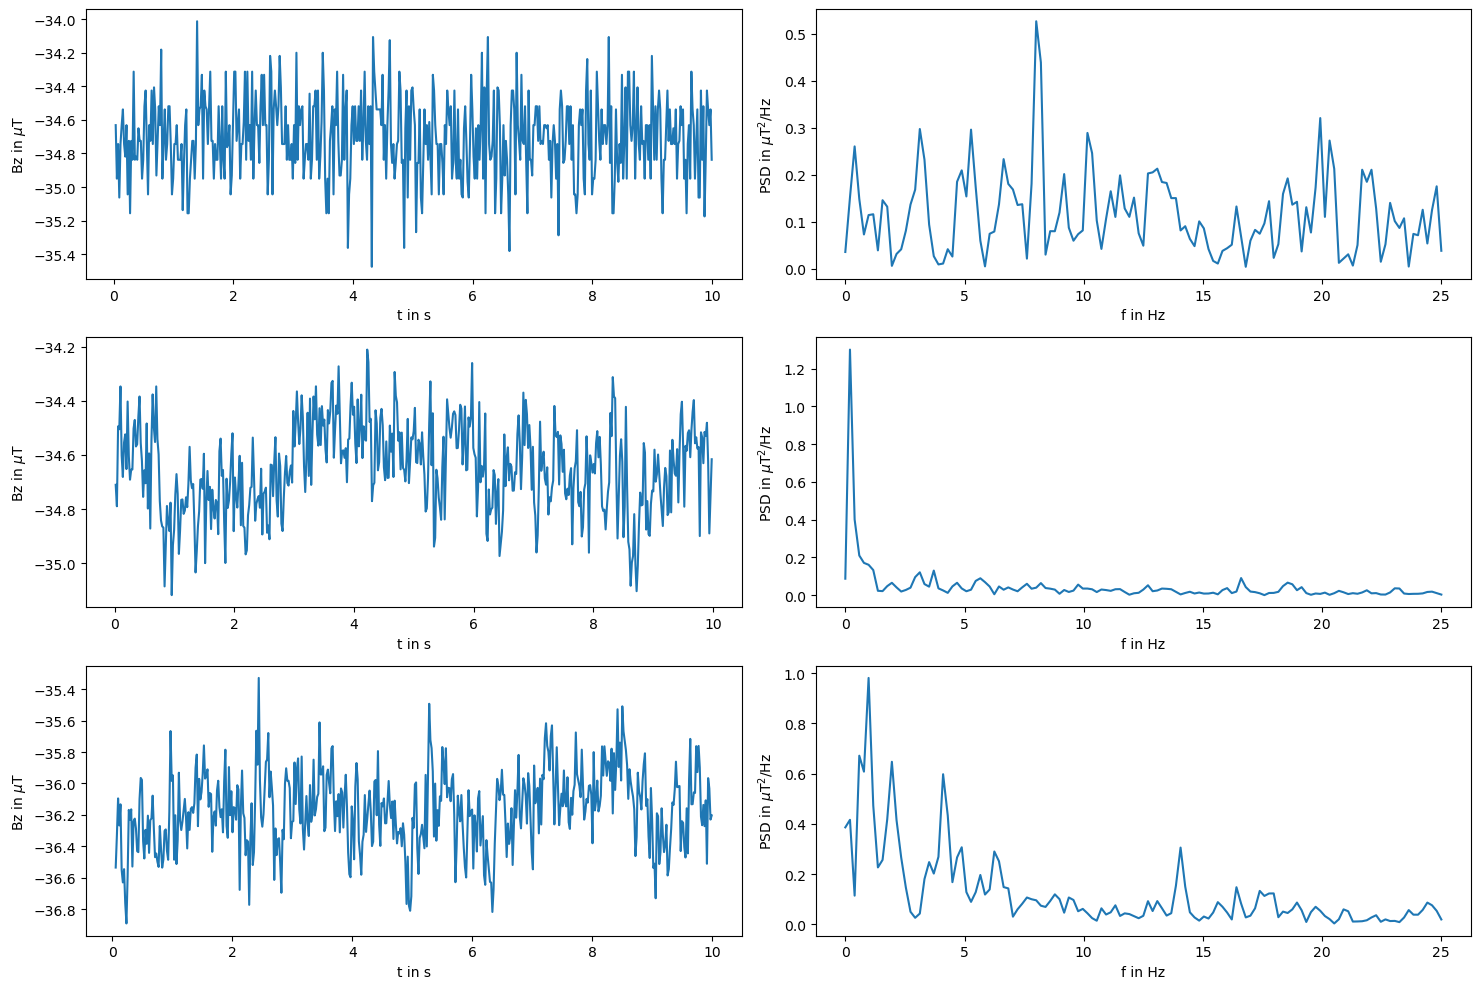

In [10]:
fig, ((ax1,ax4),(ax2,ax5),(ax3,ax6)) = plt.subplots(3, 2, figsize=(15, 10))

fl, PSDl = welch(louis[:,3])
fl = fl*50 #multiply by sampling rate
ax1.plot(louis[:,0],louis[:,3])
ax1.set_xlabel('t in s')
ax1.set_ylabel(r'Bz in $\mu$T')
ax4.plot(fl,PSDl)
ax4.set_xlabel('f in Hz')
ax4.set_ylabel(r'PSD in $\mu$T$^2$/Hz')

ben_d = downsample(ben[:,3],2)
fb, PSDb = welch(ben_d)
fb = fb*50 #multiply by sampling rate
ax2.plot(downsample(ben[:,0],2),ben_d)
ax2.set_xlabel('t in s')
ax2.set_ylabel(r'Bz in $\mu$T')
ax5.plot(fb,PSDb)
ax5.set_xlabel('f in Hz')
ax5.set_ylabel(r'PSD in $\mu$T$^2$/Hz')

sri_d = downsample(sri[:,3],2)
fs, PSDs = welch(sri_d)
fs = fs*50 #multiply by sampling rate
ax3.plot(downsample(sri[:,0],2),sri_d)
ax3.set_xlabel('t in s')
ax3.set_ylabel(r'Bz in $\mu$T')
ax6.plot(fs,PSDs)
ax6.set_xlabel('f in Hz')
ax6.set_ylabel(r'PSD in $\mu$T$^2$/Hz')

plt.tight_layout()  # Adjusts spacing
plt.show()

## PSD
We can see the frequency components differ by quite a bit. While data acquired with the phones of Ben and Sriram seem more similar, this could be explained by both of them using an ihpone. It seems probable that similar devices have similar noise componenets.

Text(0, 0.5, 'PSD in $\\mu$T$^2$/Hz')

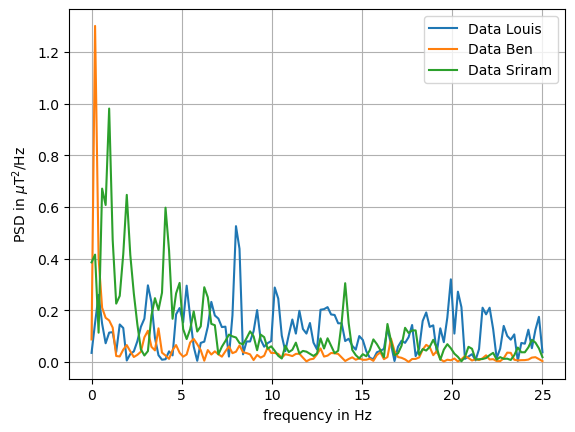

In [12]:
plt.plot(fl,PSDl,label='Data Louis')
plt.plot(fb,PSDb,label='Data Ben')
plt.plot(fs,PSDs,label='Data Sriram')
plt.grid()
plt.legend()
plt.xlabel('frequency in Hz')
plt.ylabel(r'PSD in $\mu$T$^2$/Hz')


## Longer Acquisition
Next, I want to analyze if systematic errors become more visible in the allan deviation for longer acquisition times, i.e., longer time scales. For this a dataset with an acquisition time of [...] minutes will be used.

In [14]:
long = read_csv_numpy("C:/Users/ledel/QuantumHardwareLab/B0field/Data/raw/earth_room_long.csv")
long2 = read_csv_numpy("C:/Users/ledel/QuantumHardwareLab/B0field/Data/raw/earth_room_long_2.csv")

Data shape: (15000, 5)
Data shape: (35001, 5)


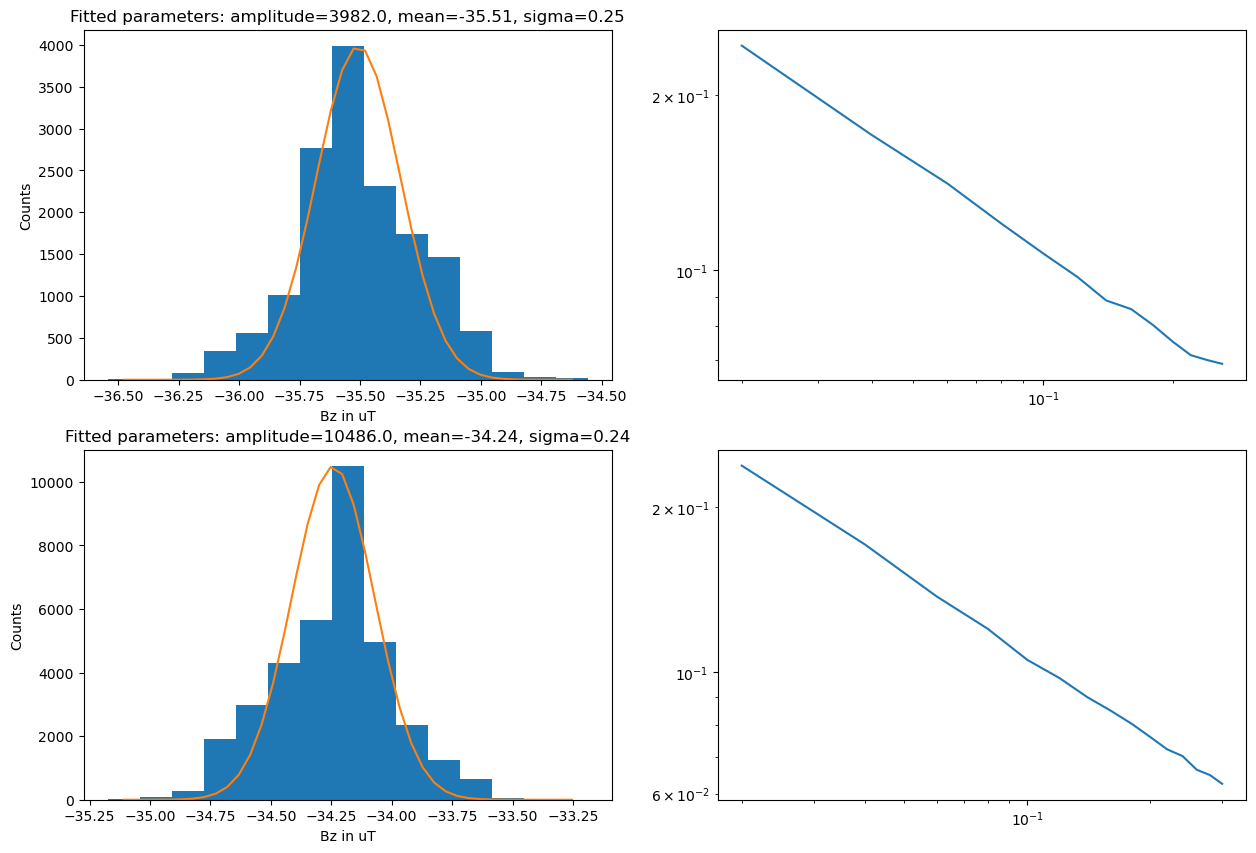

In [15]:
fig, ((ax1,ax4), (ax2,ax5)) = plt.subplots(2, 2, figsize=(15, 10))

counts_long, bin_edges, patches = ax1.hist(long[:,3],bins=15)
bins_long = (bin_edges[:-1] + bin_edges[1:]) / 2
#popt, pcov = curve_fit(gaussian, bins_l, counts_l, p0=[max(counts_l), np.mean(louis[:,3]), np.std(louis[:,3])])
#ax1.hist(louis[:,3], bins=50, label='Histogram')
#ax1.plot(bins_l, gaussian(bins_l, *popt), 'r-', linewidth=2, label='Fit')
range_long = np.linspace(bins_long[0],bins_long[14],40)
ax1.plot(range_long,gaussian(range_long,max(counts_long), np.mean(long[:,3]), np.std(long[:,3])))
ax1.set_title(f"Fitted parameters: amplitude={max(counts_long)}, mean={round(np.mean(long[:,3]),2)}, sigma={round(np.std(long[:,3]),2)}")
ax1.set_ylabel('Counts')
ax1.set_xlabel('Bz in uT')

allan_long,tau_long = allan(long[:,3],long[:,0],1)
tlong = np.linspace(1,len(allan_long),len(allan_long))*tau_long
ax4.plot(tlong,allan_long)
ax4.set_yscale('log')
ax4.set_xscale('log')

counts_long2, bin_edges, patches = ax2.hist(long2[:,3],bins=15)
bins_long2 = (bin_edges[:-1] + bin_edges[1:]) / 2
#popt, pcov = curve_fit(gaussian, bins_l, counts_l, p0=[max(counts_l), np.mean(louis[:,3]), np.std(louis[:,3])])
#ax1.hist(louis[:,3], bins=50, label='Histogram')
#ax1.plot(bins_l, gaussian(bins_l, *popt), 'r-', linewidth=2, label='Fit')
range_long2 = np.linspace(bins_long2[0],bins_long2[14],40)
ax2.plot(range_long2,gaussian(range_long2,max(counts_long2), np.mean(long2[:,3]), np.std(long2[:,3])))
ax2.set_title(f"Fitted parameters: amplitude={max(counts_long2)}, mean={round(np.mean(long2[:,3]),2)}, sigma={round(np.std(long2[:,3]),2)}")
ax2.set_ylabel('Counts')
ax2.set_xlabel('Bz in uT')

allan_long2,tau_long2 = allan(long2[:,3],long2[:,0],1)
tlong2 = np.linspace(1,len(allan_long2),len(allan_long2))*tau_long2
ax5.plot(tlong2,allan_long2)
ax5.set_yscale('log')
ax5.set_xscale('log')

In [16]:
print(allan_long2)
print(allan_long)

[0.23845651 0.17124371 0.13754584 0.1200576  0.10532917 0.09754001
 0.09011654 0.08506353 0.08052771 0.07614247 0.07228742 0.07025886
 0.06632701 0.0648736  0.06252376]
[0.24375761 0.17104367 0.14097284 0.12025956 0.10684365 0.09734004
 0.0886375  0.08564394 0.08034018 0.07520797 0.07133047 0.06997827
 0.06893339]


#### Reproducability
We did the same measurement for the earth magnetic field again on a different day. While it might be interesting to also look at the other results again, I meainly want to double check whether the PSD will show the same characteristics. However, only 2 instead of three measurements.


In [18]:
louis2 = read_csv_numpy("C:/Users/ledel/QuantumHardwareLab/B0field/Data/raw/earth_room_louis_2.csv")
ben2 = read_csv_numpy("C:/Users/ledel/QuantumHardwareLab/B0field/Data/raw/earth_room_ben_2.csv")

Data shape: (500, 5)
Data shape: (999, 5)


Text(0, 0.5, 'PSD in $\\mu$T$^2$/Hz')

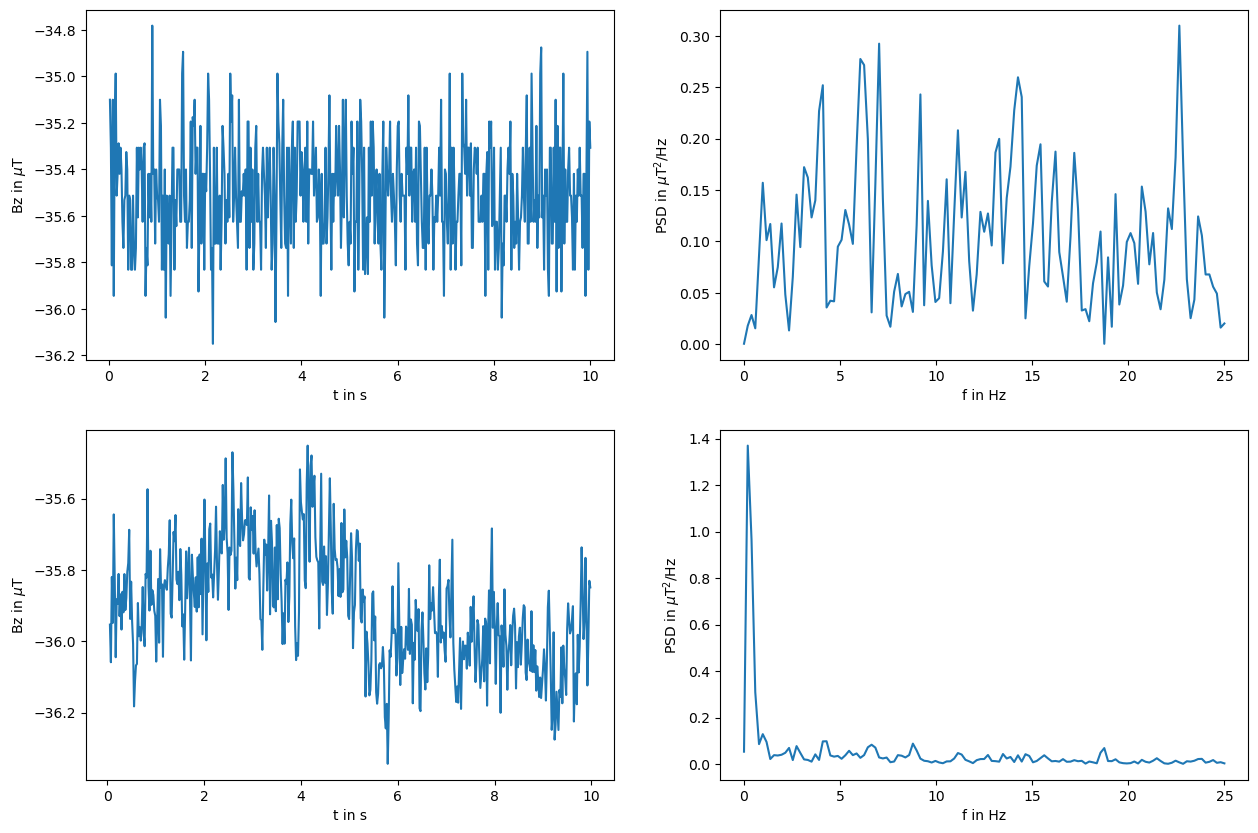

In [19]:
fig, ((ax1,ax4),(ax2,ax5)) = plt.subplots(2, 2, figsize=(15, 10))

fl2, PSDl2 = welch(louis2[:,3])
fl2 = fl2*50 #multiply by sampling rate
ax1.plot(louis2[:,0],louis2[:,3])
ax1.set_xlabel('t in s')
ax1.set_ylabel(r'Bz in $\mu$T')
ax4.plot(fl2,PSDl2)
ax4.set_xlabel('f in Hz')
ax4.set_ylabel(r'PSD in $\mu$T$^2$/Hz')

ben_d2 = downsample(ben2[:,3],2)
fb2, PSDb2 = welch(ben_d2)
fb2 = fb2*50 #multiply by sampling rate
ax2.plot(downsample(ben2[:,0],2),ben_d2)
ax2.set_xlabel('t in s')
ax2.set_ylabel(r'Bz in $\mu$T')
ax5.plot(fb2,PSDb2)
ax5.set_xlabel('f in Hz')
ax5.set_ylabel(r'PSD in $\mu$T$^2$/Hz')

Text(0, 0.5, 'PSD in $\\mu$T$^2$/Hz')

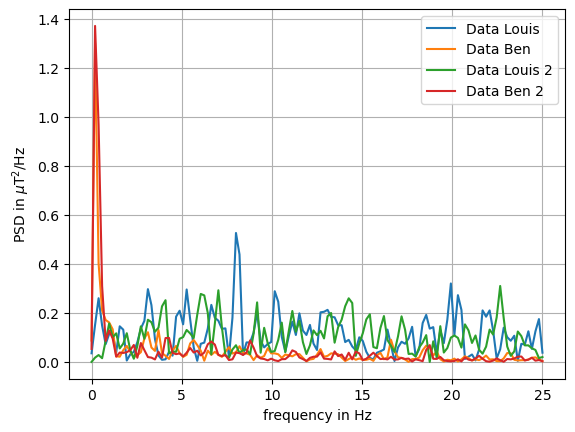

In [20]:
plt.plot(fl,PSDl,label='Data Louis')
plt.plot(fb,PSDb,label='Data Ben')
plt.plot(fl2,PSDl2,label='Data Louis 2')
plt.plot(fb2,PSDb2,label='Data Ben 2')
plt.grid()
plt.legend()
plt.xlabel('frequency in Hz')
plt.ylabel(r'PSD in $\mu$T$^2$/Hz')
